### 1. Load molecule

In [1]:
from qdk.chemistry import Molecule

In [2]:
caffeine = Molecule.from_xyz("data/xyz/caffeine.xyz")

In [3]:
caffeine

JsmolWidget(layout=Layout(align_self='stretch', height='400px'))

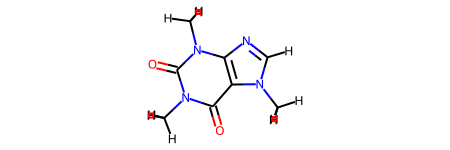

In [4]:
caffeine.mol

In [5]:
type(caffeine.mol)

rdkit.Chem.rdchem.Mol

In [6]:
caffeine.smiles

'[H]Cn1c(=O)c2c(ncn2C)n(C)c1=O'

In [7]:
caffeine.num_electrons

102

In [8]:
caffeine.atoms

[1, 6, 7, 8]

### 2. Load Broombridge and simulate in Q#

In [9]:
%%writefile GetEnergyByTrot.qs
namespace Microsoft.Quantum.Chemistry.Trotterization {
    open Microsoft.Quantum.Core;
    open Microsoft.Quantum.Intrinsic;
    open Microsoft.Quantum.Canon;
    open Microsoft.Quantum.Chemistry;
    open Microsoft.Quantum.Chemistry.JordanWigner;  
    open Microsoft.Quantum.Simulation;
    open Microsoft.Quantum.Characterization;
    open Microsoft.Quantum.Convert;
    open Microsoft.Quantum.Math;

    operation GetEnergyByTrotterization (
        JWEncodedData: JordanWignerEncodingData,
        nBitsPrecision : Int, 
        trotterStepSize : Double, 
        trotterOrder : Int
    ) : (Double, Double) {

        let (nSpinOrbitals, fermionTermData, inputState, energyOffset) = JWEncodedData!;
        let (nQubits, (rescaleFactor, oracle)) = TrotterStepOracle(JWEncodedData, trotterStepSize, trotterOrder);
        let statePrep = PrepareTrialState(inputState, _);
        let phaseEstAlgorithm = RobustPhaseEstimation(nBitsPrecision, _, _);
        let estPhase = EstimateEnergy(nQubits, statePrep, oracle, phaseEstAlgorithm);
        let estEnergy = estPhase * rescaleFactor + energyOffset;

        return (estPhase, estEnergy);
    }
}


Overwriting GetEnergyByTrot.qs


In [10]:
%%writefile TrotterizationExample.csproj
<Project Sdk="Microsoft.Quantum.Sdk/0.14.2011120240">
    <PropertyGroup>
        <OutputType>Exe</OutputType>
        <TargetFramework>netcoreapp3.1</TargetFramework>
    </PropertyGroup>
    <ItemGroup>
        <PackageReference Include="Microsoft.Quantum.Chemistry" Version="0.14.2011120240" />
  </ItemGroup>
</Project>

Overwriting TrotterizationExample.csproj


In [11]:
import qsharp

Preparing Q# environment...
..

In [12]:
from qdk.chemistry.broombridge import load_and_encode

Adding package microsoft.quantum.chemistry.jupyter.

In [13]:
qsharp.reload()

from Microsoft.Quantum.Chemistry.Trotterization import GetEnergyByTrotterization

Reloading workspace.

### Caffeine

In [14]:
encoded_data_caffeine = load_and_encode("data/broombridge/caffeine.yaml")

In [15]:
%%time
GetEnergyByTrotterization.simulate(
    JWEncodedData=encoded_data_caffeine,
    nBitsPrecision=7,
    trotterStepSize=0.4,
    trotterOrder=1)

CPU times: user 2.24 ms, sys: 2.71 ms, total: 4.95 ms
Wall time: 934 ms


(-0.03681553890925539, 883.2457692010214)

In [16]:
%%time
GetEnergyByTrotterization.estimate_resources(
    JWEncodedData=encoded_data_caffeine, 
    nBitsPrecision=7,
    trotterStepSize=0.4, 
    trotterOrder=1)

CPU times: user 4.02 ms, sys: 5.11 ms, total: 9.13 ms
Wall time: 1.71 s


{'CNOT': 211616,
 'QubitClifford': 124794,
 'R': 81068,
 'Measure': 317,
 'T': 0,
 'Depth': 0,
 'Width': 5,
 'QubitCount': 5,
 'BorrowedWidth': 0}

### Pyridine

In [17]:
encoded_data_pyridine = load_and_encode("data/broombridge/pyridine.yaml")

In [19]:
import qsharp

In [20]:
import qsharp.azure

In [21]:
encoded_data_H = load_and_encode("data/broombridge/hydrogen_0.2.yaml")

In [26]:
%%time
GetEnergyByTrotterization.simulate(
    JWEncodedData=encoded_data_H, 
    nBitsPrecision=7,
    trotterStepSize=0.4,
    trotterOrder=1)

CPU times: user 3.75 ms, sys: 3.47 ms, total: 7.22 ms
Wall time: 322 ms


(-0.4172427743048944, -1.1419413817622361)